In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-mipt-2024-hw1-data/t10k-labels-idx1-ubyte
/kaggle/input/dl-mipt-2024-hw1-data/sample_submission.csv
/kaggle/input/dl-mipt-2024-hw1-data/t10k-images-idx3-ubyte
/kaggle/input/dl-mipt-2024-hw1-data/fashion-mnist_test.csv
/kaggle/input/dl-mipt-2024-hw1-data/fashion-mnist_train.csv
/kaggle/input/dl-mipt-2024-hw1-data/train-labels-idx1-ubyte
/kaggle/input/dl-mipt-2024-hw1-data/train-images-idx3-ubyte


# Dataset Description

**Fashion-MNIST** – аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.

Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введённым описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор их 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (label) – принадлежность изображения к классу, а последний – его уникальный номер (id). Остальные столбцы – пиксели изображения.
Проведите первичный анализ данных, чтобы определить наличие NaN значений.
Тестовая выборка (на основе которой должно быть получено исследование) содержит все те же столбцы, кроме label.

# Расшифровка классов (label), к которым принадлежат изображения:

0. T-shirt/top – футболка
1. Trouser – брюки
2. Pullover – свитер
3. Dress – платье
4. Coat – пальто
5. Sandal – сандалия
6. Shirt – рубашка
7. Sneaker – кроссовок
8. Bag – сумка
9. Ankle boot – сапог

# Структура данных:

fmnist_train.csv – обучающая выборка
fmnist_test.csv – тестовая выборка (на которой должно быть получено предсказание)
sample_submission.csv – пример решения

In [74]:
import torch
from torch import nn
from torch import optim

In [183]:
fashion_mnist_train_df = pd.read_csv('/kaggle/input/dl-mipt-2024-hw1-data/fashion-mnist_train.csv')
train_df = fashion_mnist_train_df.copy()

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [110]:
train_df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

## Data preparation

In [111]:
train_df.isnull().sum().sum()

0

In [184]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Splitting data into features and labels
X = train_df.iloc[:, 1:].values / 255  # Normalize data
y = train_df.iloc[:, 0].values

y = to_categorical(y)         # Convert labels to one-hot encoding
X = X.reshape(-1, 1, 28, 28)  # Reshape X to fit PyTorch expectations

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert one-hot encoded labels back to class indices for PyTorch
y_train_indices = np.argmax(y_train, axis=1)
y_val_indices = np.argmax(y_val, axis=1)

# Convert features and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_indices, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model preparation

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

## Model training and Model validation

In [186]:
# Define the loss function for calculating how well the model is performing
criterion = nn.CrossEntropyLoss()

# Define the optimizer for updating the model's weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode to disable dropout or batch normalization
    total_loss = 0
    total = 0
    correct = 0
    
    losses = []     # List to store loss values for validation
    accuracies = [] # List to store accuracy values for validation

    # Iterate over the validation data loader
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)  # Calculate average loss over all validation batches
    losses.append(avg_loss)
    accuracy = correct / total * 100         # Calculate accuracy percentage
    accuracies.append(accuracy)
    
    return avg_loss, accuracy

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to training mode to enable dropout, batch normalization, etc.
    losses_train = []
    accuracies_train = []
    val_losses = []
    val_accuracies = []

    # Start training loop over the number of epochs
    for epoch in range(num_epochs):
        total_loss = 0
        total = 0
        correct = 0

        # Iterate over the training data loader
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute gradients of all variables wrt. loss
            optimizer.step()       # Update model weights based on computed gradients

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)  # Calculate average loss over training data
        losses_train.append(avg_loss)
        accuracy = correct / total * 100  # Calculate accuracy percentage for training
        accuracies_train.append(accuracy)
        
        # Perform validation after each epoch
        avg_val_loss, val_accuracy = validate(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return losses_train, accuracies_train, val_losses, val_accuracies

In [187]:
# Execute training
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Epoch [1/30], Train Loss: 0.5425, Val Loss: 0.4369, Val Accuracy: 84.37%
Epoch [2/30], Train Loss: 0.3938, Val Loss: 0.3750, Val Accuracy: 86.28%
Epoch [3/30], Train Loss: 0.3521, Val Loss: 0.3398, Val Accuracy: 87.40%
Epoch [4/30], Train Loss: 0.3260, Val Loss: 0.3163, Val Accuracy: 88.29%
Epoch [5/30], Train Loss: 0.3094, Val Loss: 0.2971, Val Accuracy: 88.92%
Epoch [6/30], Train Loss: 0.2928, Val Loss: 0.2814, Val Accuracy: 89.48%
Epoch [7/30], Train Loss: 0.2809, Val Loss: 0.2665, Val Accuracy: 89.98%
Epoch [8/30], Train Loss: 0.2689, Val Loss: 0.2526, Val Accuracy: 90.65%
Epoch [9/30], Train Loss: 0.2588, Val Loss: 0.2455, Val Accuracy: 90.77%
Epoch [10/30], Train Loss: 0.2498, Val Loss: 0.2353, Val Accuracy: 91.15%
Epoch [11/30], Train Loss: 0.2419, Val Loss: 0.2279, Val Accuracy: 91.67%
Epoch [12/30], Train Loss: 0.2328, Val Loss: 0.2178, Val Accuracy: 91.76%
Epoch [13/30], Train Loss: 0.2254, Val Loss: 0.2125, Val Accuracy: 92.38%
Epoch [14/30], Train Loss: 0.2207, Val Loss: 0.

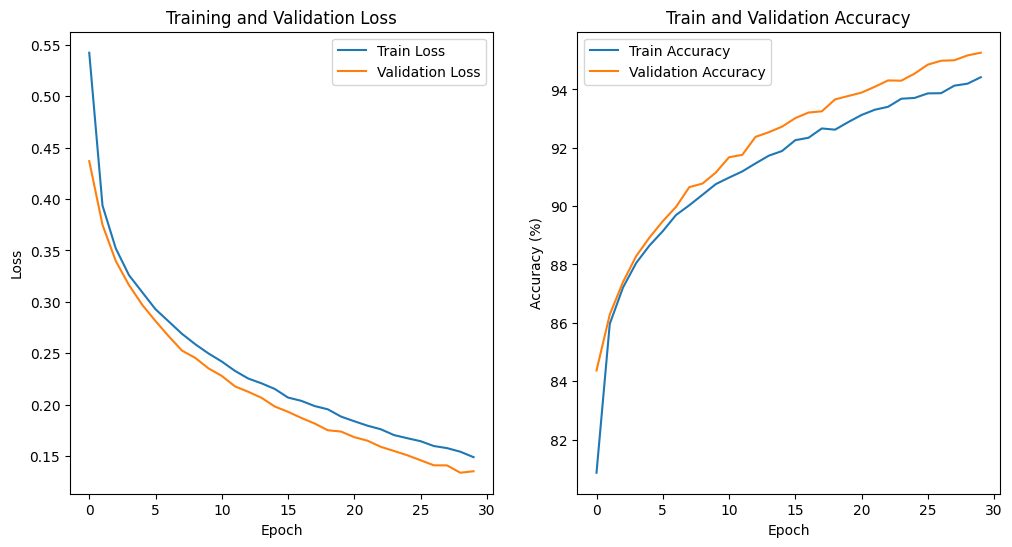

In [188]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## Model testing

In [189]:
fashion_mnist_test_df = pd.read_csv('/kaggle/input/dl-mipt-2024-hw1-data/fashion-mnist_test.csv')
test_data = fashion_mnist_test_df.copy()

X_test = test_data.iloc[:, 1:].values / 255.0  # Only normalize once
X_test = X_test.reshape(-1, 1, 28, 28)  # Reshape for PyTorch (N, C, H, W)

# Convert to torch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradients needed during inference
    outputs = model(X_test_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_labels = torch.argmax(probabilities, dim=1).numpy()  # Get the predicted labels

In [190]:
report = pd.DataFrame({
    'Id': range(0, len(predicted_labels)),
    'Category': predicted_labels
})

report.to_csv('submission_result.csv', index=False)